In [98]:
import wandb
import torch
api = wandb.Api()


equation = 'KdV'
# Specify your project and entity
project = f"{equation}_9_25"
entity = "kaist_yegonkim"

# Get all runs from the project
runs = api.runs(f"{entity}/{project}", filters={"state": "finished"})

# Filter runs based on configurations and collect metrics
filtered_metrics = []
for run in runs:
    
    # Example: Filter runs where batch_size is 32 and learning_rate is 0.001
    if run.config.get('comment') is None and run.config.get('mean_field') == False:
        # Collect specific metrics, e.g., 'accuracy' and 'loss'
        metrics = {
            'seed': run.config.get('seed'),
            'initial_selection_method': run.config.get('initial_selection_method'),
            'post_selection_method': run.config.get('post_selection_method'),
        }
        history = run.scan_history()
        run_metrics = []
        for step in history:
            step_metrics = {
                'step': step.get('_step'),
                'datasize': step.get('datasize'),
                'rmse': step.get('test/L2'),
                'nrmse': step.get('test/Relative_L2'),
                'mae': step.get('test/MAE'),
                '99': step.get('test/99_L2'),
                '95': step.get('test/95_L2'),
                '50': step.get('test/50_L2'),
            }
            if step_metrics['rmse'] is not None:
                run_metrics.append(step_metrics)
        if len(run_metrics) == 0:
            continue
        # if metrics['seed'] in [2, 3]:
        #     continue
        run_metrics = {k: [run_metrics[i][k] for i in range(len(run_metrics))] for k in run_metrics[0]}
        run_metrics = {k: torch.tensor(v) for k, v in run_metrics.items()}
        
        metrics['metrics'] = run_metrics

        filtered_metrics.append(metrics)

# filtered_metrics:
# [{'seed': 0, 'initial_selection_method': 'random', 'post_selection_method': 'random', 'metrics': {'step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'datasize': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rmse': [

In [99]:
grouped_metrics = {}
for metrics in filtered_metrics:
    key = (metrics['initial_selection_method'], metrics['post_selection_method'])
    if key not in grouped_metrics:
        grouped_metrics[key] = [] 
    grouped_metrics[key].append(metrics['metrics'])
for key in grouped_metrics:
    grouped_metrics[key] = {k: torch.stack([metrics[k] for metrics in grouped_metrics[key]]) for k in grouped_metrics[key][0] if k != 'step'}

In [100]:
# convert keys as follows
conversion_0 = {'random': 'Random', 'variance': 'QbC', 'lcmd_hidden': 'LCMD', 'stochastic_1.0': 'SBAL'}
conversion_1 = {'all': '', 'flexible_max': '+FlexAL'}

grouped_metrics = {f"{conversion_0[k[0]]}{conversion_1[k[1]]}": v for k, v in grouped_metrics.items()}

# grouped_metrics:
# {'Random': {'datasize': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
#                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
#             'rmse': tensor([[
#                             [
#

In [101]:
mean_log_metrics = {k: {metric: torch.mean(torch.log(v[metric]), dim=(0,1)).item() for metric in v} for k, v in grouped_metrics.items()}
std_log_metrics = {k: {metric: torch.std(torch.mean(torch.log(v[metric]), dim=1), dim=0).item() for metric in v} for k, v in grouped_metrics.items()}

In [102]:
import pandas as pd
import numpy as np

df = pd.DataFrame(mean_log_metrics)
df_std = pd.DataFrame(std_log_metrics)


print(df)
print(df_std)

df.to_csv(f'main_mean_{equation}.csv')
df_std.to_csv(f'main_std_{equation}.csv')


            Random       QbC      LCMD      SBAL  SBAL+FlexAL
datasize  7.677339  7.677339  7.677339  7.677339     7.677339
rmse     -0.468384 -0.558423 -0.432880 -0.692970    -0.708050
nrmse    -1.908345 -1.903840 -1.796648 -2.054796    -2.072971
mae      -2.733045 -2.769797 -2.628432 -2.906300    -2.930838
99        2.002801  1.527907  1.655954  1.537310     1.532465
95        1.013457  0.847691  1.027941  0.726835     0.721741
50       -1.955715 -1.543258 -1.535453 -1.731754    -1.749163
            Random       QbC      LCMD      SBAL  SBAL+FlexAL
datasize  0.000000  0.000000  0.000000  0.000000     0.000000
rmse      0.037051  0.019541  0.032399  0.010605     0.018063
nrmse     0.028006  0.020395  0.030990  0.007225     0.022293
mae       0.025531  0.016584  0.036450  0.009915     0.016602
99        0.122843  0.016445  0.024602  0.025967     0.014691
95        0.029266  0.007178  0.024681  0.013217     0.034509
50        0.026730  0.014546  0.034920  0.018382     0.035058


In [103]:
average_metrics = {key: {k: v.float().mean(dim=0) for k, v in grouped_metrics[key].items()} for key in grouped_metrics}
std_metrics = {key: {k: v.float().std(dim=0) for k, v in grouped_metrics[key].items()} for key in grouped_metrics}

metric_names = {'rmse': 'RMSE', 'nrmse': 'NRMSE', 'mae': 'MAE', '99': '99% quantile RMSE', '95': '95% quantile RMSE', '50': '50% quantile RMSE'}

In [104]:
# from matplotlib import pyplot as plt

# for metric in metric_names:
#     plt.figure()
#     for key in average_metrics:
#         plt.errorbar(average_metrics[key]['datasize'], average_metrics[key][metric], yerr=std_metrics[key][metric], label=key)
#     plt.xlabel('Datasize')
#     plt.ylabel(metric_names[metric])
#     plt.legend()
#     plt.show()

# # plt.figure()
# # for key in average_metrics:
# #     plt.errorbar(average_metrics[key]['datasize'], average_metrics[key]['rmse'], yerr=std_metrics[key]['rmse'], label=key)
# # plt.xlabel('Datasize')
# # plt.ylabel('RMSE')
# # plt.legend()
# # plt.show()


/tmp/ipykernel_13134/815735838.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


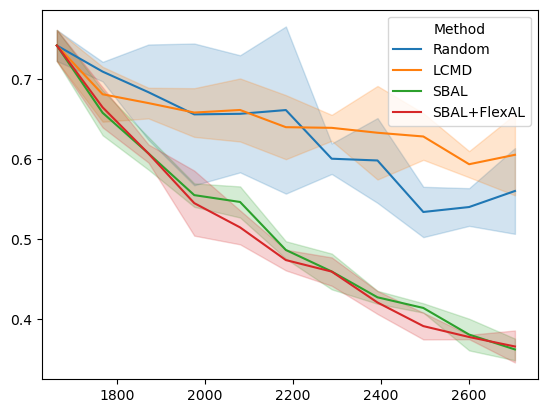

/tmp/ipykernel_13134/815735838.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


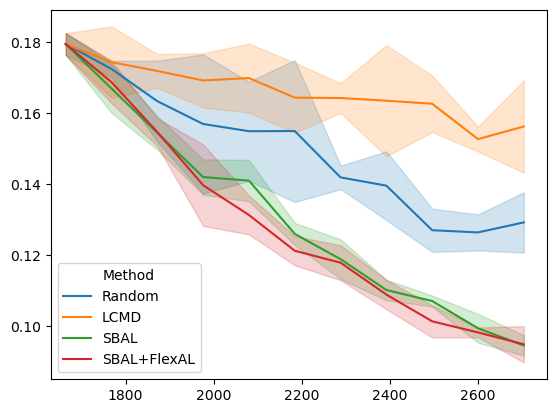

/tmp/ipykernel_13134/815735838.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


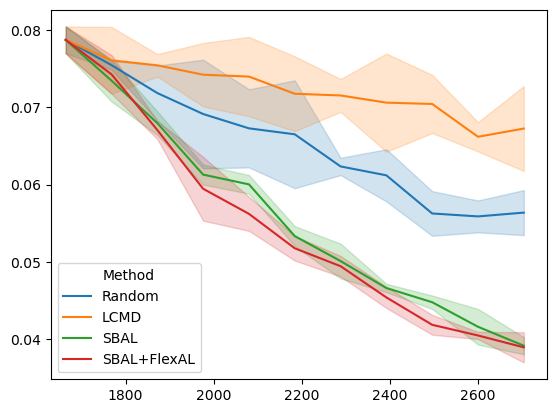

/tmp/ipykernel_13134/815735838.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


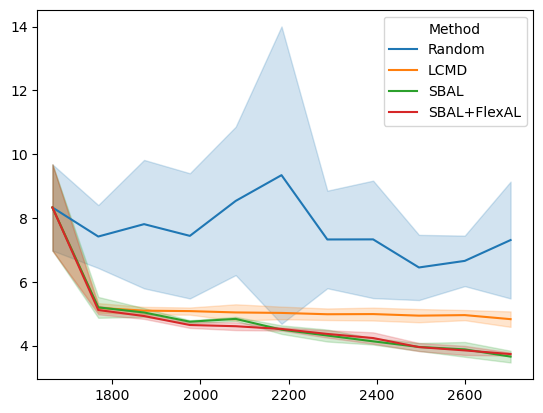

/tmp/ipykernel_13134/815735838.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


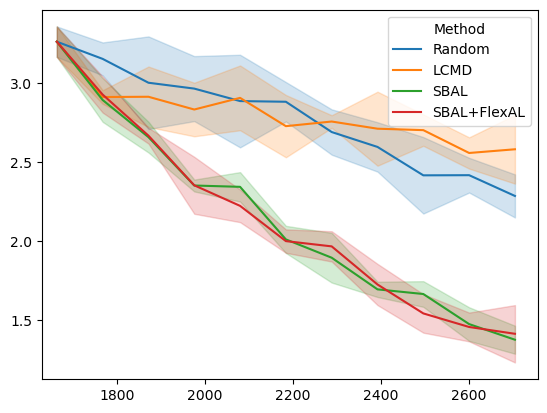

/tmp/ipykernel_13134/815735838.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/home/yegonkim/.conda/envs/lupi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


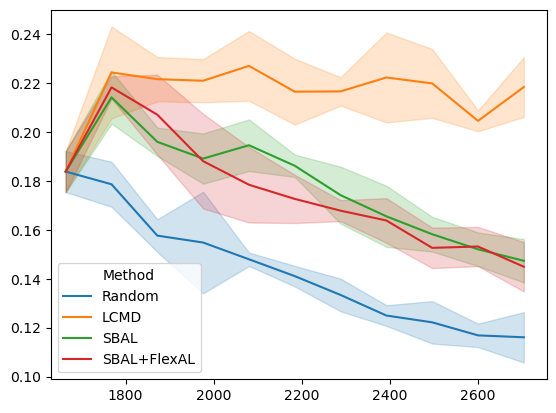

In [107]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

# Convert your tensor data into a pandas DataFrame for easier plotting with Seaborn
plot_data = []
for key in average_metrics:
    datasize = average_metrics[key]['datasize'].numpy()
    for metric in metric_names:
        mean_values = average_metrics[key][metric].numpy()
        std_values = std_metrics[key][metric].numpy()
        
        for i in range(len(datasize)):
            plot_data.append({
                'Datasize': datasize[i],
                'Mean': mean_values[i],
                'Std': std_values[i],
                'Method': key,
                'Metric': metric_names[metric]
            })

# Create DataFrame
df_plot = pd.DataFrame(plot_data)

# remove QbC and LCMD and Random
df_plot = df_plot[df_plot['Method'] != 'QbC']
# df_plot = df_plot[df_plot['Method'] != 'LCMD']
# df_plot = df_plot[df_plot['Method'] != 'Random']

# Plot with Seaborn
for metric in metric_names.values():
    plt.figure()
    # Plot the mean lines without markers
    sns.lineplot(
        data=df_plot[df_plot['Metric'] == metric], 
        x='Datasize', 
        y='Mean', 
        hue='Method', 
        style='Method', 
        dashes=False,  # Disable dashes, just solid lines
        ci=None
    )
    
    # Add shaded error bars
    for method in df_plot['Method'].unique():
        subset = df_plot[(df_plot['Metric'] == metric) & (df_plot['Method'] == method)]
        plt.fill_between(
            subset['Datasize'], 
            subset['Mean'] - subset['Std'], 
            subset['Mean'] + subset['Std'], 
            alpha=0.2,  # Transparency for the shaded area
            color=sns.color_palette()[list(df_plot['Method'].unique()).index(method)]
        )
    
    # no xlabel and ylabel

    plt.xlabel(None)
    plt.ylabel(None)
    # plt.legend(title='Method')
    plt.xlim(left=1630)

    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()
